In [1]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [2]:
## Downloading the data from the source

url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' %filename)
    else:
        print(statinfo.st_size)
        raise Exception(
        'Failed to verify ' + filename + '. Can you get it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
## reading a data into string

def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size: %d' %len(words))

Data size: 17005207


In [6]:
## building a dictionary and replacing rare words with UNK token

vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0 #dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words # to reduce memory

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [11]:
#generating the training batch for a skip gram model

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size %num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape = (batch_size), dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    span = 2 * skip_window + 1 #[skip_window target skip_window]
    buffer = collections.deque(maxlen = span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    for i in range(batch_size // num_skips):
        target = skip_window #target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size = 8, num_skips = num_skips, skip_window = skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'originated', 'term', 'a', 'as', 'term', 'of', 'originated']


In [15]:
## Training a skip gram model

batch_size = 128
embedding_size = 128 #Dimensions of the embedding vector
skip_window = 1 #How many words to consider left and right.
num_skips = 2 #How many times to reuse an input to generate a label

#We pick a random validation set to sample nearest neighbors. Here we limit the validation samples to the word which have low numeric id , which by construction are also the most frequent.

valid_size = 16 #random set of words to evaluate similarity on
valid_window = 100 #Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 #number of negative samples to target.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    
    #Input data
    train_dataset = tf.placeholder(tf.int32, shape = [batch_size])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype = tf.int32)
    
    #variables
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev = 1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    #model
    #looking up embeddings for the input
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    #compute the softmax loss, using a sample of negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights = softmax_weights, biases = softmax_biases, inputs = embed, labels = train_labels, num_sampled = num_sampled, num_classes = vocabulary_size))
    
    #optimizer
    #The optimiizer will optimize the softmax weights and embeddings. This is because the embeddings are defined as a variable quantity and the optimizer's 'minimize' method will by default modify all variable quantities that contribute to the tensor it is passed.
    
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    #computing the similarity between the minibatch examples and all embeddings. We use the cosine distance:
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims = True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [16]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.012075
Nearest to more: pamphilus, mentioned, stereotypes, magdalena, scam, tasks, realaudio, blackbeard,
Nearest to this: jakob, lassen, unger, incomprehensible, reruns, cytosol, understandable, utamaro,
Nearest to such: esprit, conceivably, into, novum, kary, dismantle, shipment, sliced,
Nearest to world: nailed, viollet, hoover, centriole, ferrara, doorways, learner, minotaur,
Nearest to so: neck, angers, reformed, shed, regularly, familia, calamities, zum,
Nearest to nine: kinshasa, zed, markov, shout, occultist, nga, honestly, burn,
Nearest to not: browsing, marley, jelly, gz, revere, cadet, regi, archie,
Nearest to their: lick, cleric, literal, hammer, swear, oppressive, medway, referral,
Nearest to other: favouring, cathar, estudios, tuvalu, protectorate, ugle, payload, applets,
Nearest to they: embellished, overseeing, asserted, musically, leds, offseason, durrani, margaret,
Nearest to zero: scarce, nasi, smokey, aliyah, dup, cronquist, jas

Average loss at step 52000: 3.438458
Average loss at step 54000: 3.427972
Average loss at step 56000: 3.435831
Average loss at step 58000: 3.394337
Average loss at step 60000: 3.392966
Nearest to more: less, highly, most, larger, smaller, very, rather, greater,
Nearest to this: which, it, there, the, that, what, some, hells,
Nearest to such: well, known, these, certain, many, having, including, various,
Nearest to world: obelisk, shady, nation, crewe, band, largest, centimes, hermione,
Nearest to so: if, too, then, sainthood, miracles, therefore, maoism, derailed,
Nearest to nine: eight, six, four, seven, five, three, one, zero,
Nearest to not: still, usually, typically, considered, never, generally, now, easily,
Nearest to their: its, his, her, the, some, several, our, these,
Nearest to other: various, different, including, many, opacity, educational, others, sidelines,
Nearest to they: we, there, you, he, she, these, etymological, it,
Nearest to zero: five, four, six, eight, seven, n

In [17]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

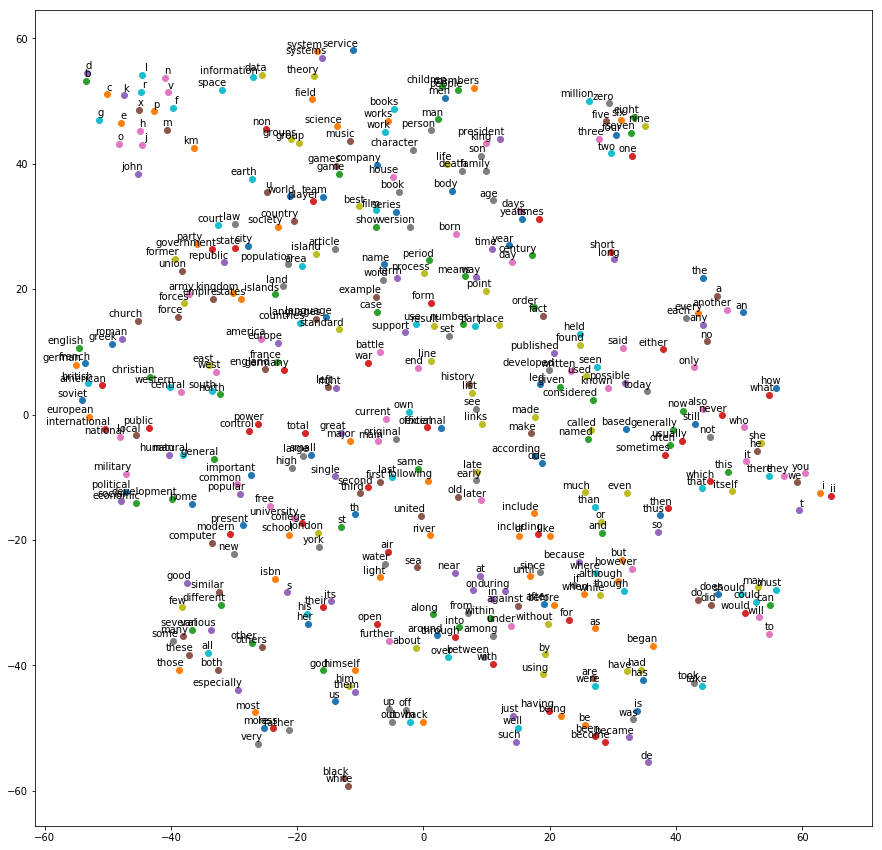

In [18]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [19]:
#using CBOW(continuous bag of words) model

data_index = 0

def generate_batch(batch_size, bag_window):
    global data_index
    span = 2 * bag_window + 1 # [ bag_window target bag_window ]
    batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        # just for testing
        buffer_list = list(buffer)
        labels[i, 0] = buffer_list.pop(bag_window)
        batch[i] = buffer_list
        # iterate to the next buffer
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:16]])

for bag_window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=4, bag_window=bag_window)
    print('\nwith bag_window = %d:' % (bag_window))
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])


data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
    labels: ['originated', 'as', 'a', 'term']

with bag_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
    labels: ['as', 'a', 'term', 'of']


In [24]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
bag_window = 2  # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64  # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights = softmax_weights, biases = softmax_biases, inputs = tf.reduce_sum(embeds, 1),
                                   labels = train_labels, num_sampled = num_sampled, num_classes = vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [25]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, bag_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 7.583234
Nearest to some: salford, bowling, idaho, posting, feeds, steiner, seychelles, underlies,
Nearest to UNK: lambdamoo, laurie, man, hyde, indictment, wong, seaweed, adrift,
Nearest to american: didache, lambeau, olivier, impedance, oses, jumbo, heuvelmans, tara,
Nearest to from: gerald, jelly, sacs, communities, blackadder, fundamentals, electress, mede,
Nearest to is: powell, literature, catamaran, indisputable, democrats, uplifting, hangs, harry,
Nearest to as: dillinger, resorts, paula, yevgeny, sudanese, disrepair, told, monsoon,
Nearest to by: rapprochement, dugout, forerunners, overkill, topsy, excludes, cumann, sockets,
Nearest to also: vulnerable, actively, fabricate, captives, voc, glibc, eisenhower, wombat,
Nearest to after: lehrer, gravitons, breathed, integrals, emoticon, disbanded, sweetheart, bullough,
Nearest to seven: cemetery, hindered, afterward, gal, d

Average loss at step 52000: 3.090574
Average loss at step 54000: 3.092638
Average loss at step 56000: 2.925653
Average loss at step 58000: 3.024113
Average loss at step 60000: 3.056820
Nearest to some: many, several, various, numerous, all, these, most, certain,
Nearest to UNK: annul, stanis, eminently, meaning, regiment, tectonics, nathanael, hegemony,
Nearest to american: canadian, america, palomino, preposition, australian, british, russian, brutus,
Nearest to from: zalta, waterborne, into, through, via, during, under, indies,
Nearest to is: was, are, becomes, has, includes, makes, means, were,
Nearest to as: monsoon, kyo, vertigo, emulator, jinshi, lima, origami, authenticated,
Nearest to by: vald, under, hellenized, inextricably, ppg, molson, stamped, unplanned,
Nearest to also: below, disambiguation, still, now, never, currently, kandinsky, sometimes,
Nearest to after: before, despite, during, following, for, nieve, until, afterwards,
Nearest to seven: five, six, eight, four, nin

In [26]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points + 1, :])

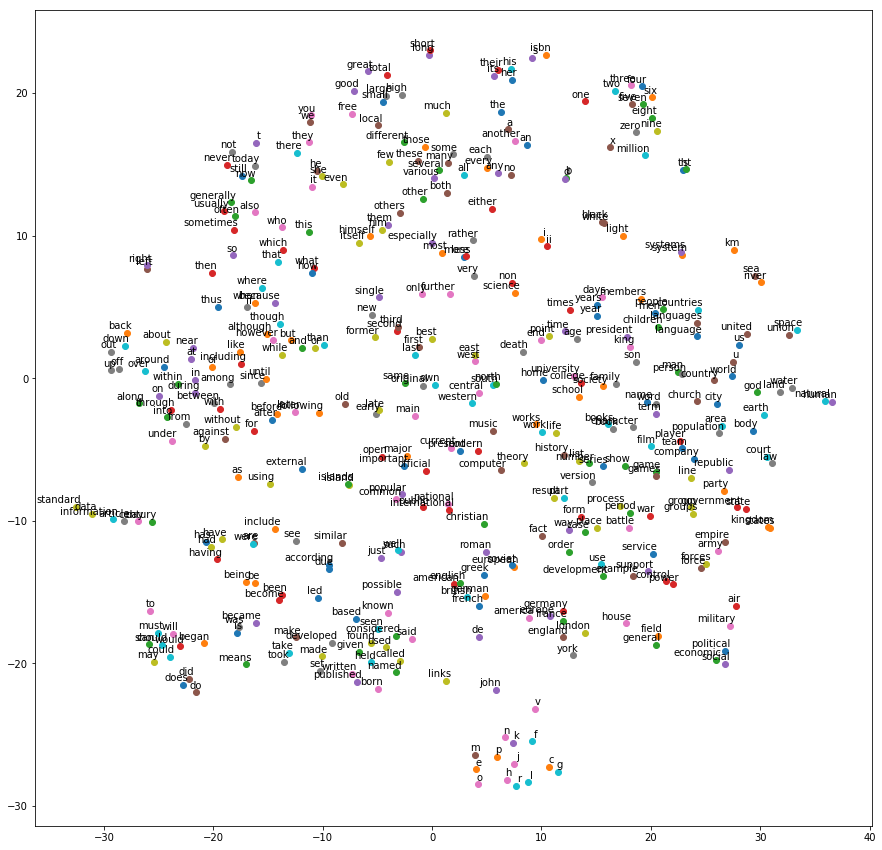

In [27]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()


words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)